Essential libraries to start working with !

In [1]:
import numpy as np
import pandas as pd 
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

Libraries that we might need in the future !

In [2]:
# import tensorflow as tf
# import keras

# from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, GlobalMaxPooling1D
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential

# from keras import regularizers
# from sklearn import preprocessing
# from sklearn.metrics import f1_score
# from scipy.stats import kurtosis, skew
# from sklearn.metrics import recall_score
# from sklearn.metrics import roc_auc_score
# from sklearn.datasets import make_circles
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import cohen_kappa_score
# from tensorflow.keras import utils as np_utils
# from sklearn.preprocessing import OneHotEncoder
# from keras.utils import to_categorical
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import precision_recall_fscore_support
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

Reading and filtering the original dataset

In [3]:
import yaml
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
def read_data(path= '../data/ppg.csv' ):
    original_df = pd.read_csv(path)
    df = original_df.copy()
    df['CREATE_DATETIME'] = pd.to_datetime(df['CREATE_DATETIME'])   # Transform to datetime

    df = df[df["READING_CATEGORY"] == "PPG"]                        # Keeping only the PPG signals 

    encoder = LabelEncoder()
    df['PATIENT_CODE'] = encoder.fit_transform(df['PATIENT_CODE'])  # Label encoding the IDs

    df.drop(columns=["ID","READING_VALUE","READING_CATEGORY"],inplace=True)
    df.rename(columns={"CREATE_DATETIME":"DATE"},inplace=True)

    print("Nuber of unique patients:",len(df["PATIENT_CODE"].unique()))
    print("Unique years of birth:",df["YEAR_OF_BIRTH"].unique())
    
    return df



In [5]:
original_df = pd.read_csv('../data/ppg.csv')
df = original_df.copy()
df['CREATE_DATETIME'] = pd.to_datetime(df['CREATE_DATETIME'])   # Transform to datetime

df = df[df["READING_CATEGORY"] == "PPG"]                        # Keeping only the PPG signals 

encoder = LabelEncoder()
df['PATIENT_CODE'] = encoder.fit_transform(df['PATIENT_CODE'])  # Label encoding the IDs

df.drop(columns=["ID","READING_VALUE","READING_CATEGORY"],inplace=True)
df.rename(columns={"CREATE_DATETIME":"DATE"},inplace=True)

print("Nuber of unique patients:",len(df["PATIENT_CODE"].unique()))
print("Unique years of birth:",df["YEAR_OF_BIRTH"].unique())
    

Nuber of unique patients: 27
Unique years of birth: [1942 1946 1947 1955 1944 1945 1940 1951 1970 2017 1956 1939 1954 1952
 1937 1948 1943 1957]


In [6]:
temp_df = df[df["PATIENT_CODE"] == 17]
temp_df.reset_index(drop=True,inplace=True)
print(temp_df)

                     DATE  PATIENT_CODE  \
0     2017-09-08 16:37:43            17   
1     2017-09-08 16:37:44            17   
2     2017-09-08 16:37:44            17   
3     2017-09-08 16:37:46            17   
4     2017-09-08 16:37:46            17   
...                   ...           ...   
12163 2018-05-03 09:13:30            17   
12164 2018-05-03 09:13:31            17   
12165 2018-05-03 09:13:32            17   
12166 2018-05-03 09:13:33            17   
12167 2018-05-03 09:13:34            17   

                                               PPG_ARRAY  YEAR_OF_BIRTH  \
0      [6, 15, 26, 42, 59, 78, 95, 100, 100, 100, 100...           2017   
1      [66, 62, 57, 52, 47, 43, 39, 34, 30, 27, 23, 2...           2017   
2      [100, 100, 100, 99, 95, 89, 82, 76, 69, 62, 56...           2017   
3      [29, 25, 22, 18, 15, 12, 9, 6, 3, 0, 0, 0, 0, ...           2017   
4      [30, 28, 26, 25, 23, 23, 23, 25, 29, 34, 41, 5...           2017   
...                              

In [7]:
def select_duplicates(df, select= None):
    print("Amount of duplicate values: \n",df.duplicated(subset=['DATE', 'PATIENT_CODE'], keep=False).value_counts())
    if select=='last':
        duplicate = df[df.duplicated(subset=['DATE', 'PATIENT_CODE'], keep= 'last')]
        print("\nlen of duplicates which removed: \n",len(duplicate))
        df_unique = df.drop_duplicates(subset=['DATE', 'PATIENT_CODE'], keep='last')    #remove duplicates keep the last one only
        print("Amount of duplicate values after droping: \n",df_unique.duplicated(subset=['DATE', 'PATIENT_CODE'], keep=False).value_counts())       
        return df_unique
    
    if select=='first':
        duplicate = df[df.duplicated(subset=['DATE', 'PATIENT_CODE'], keep= 'first')]
        print("\nlen of duplicates which removed: \n",len(duplicate))
        df_unique = df.drop_duplicates(subset=['DATE', 'PATIENT_CODE'], keep='first')    #remove duplicates keep the last one only
        print("Amount of duplicate values after droping: \n",df_unique.duplicated(subset=['DATE', 'PATIENT_CODE'], keep=False).value_counts())       
        return df_unique
    
    if select== 'deleteAll':
        duplicate = df[df.duplicated(subset=['DATE', 'PATIENT_CODE'], keep= False)]
        print("\nlen of duplicates which removed: \n",len(duplicate))
        df_unique = df.drop_duplicates(subset=['DATE', 'PATIENT_CODE'], keep= False)    #remove duplicates keep the last one only
        print("Amount of duplicate values after droping: \n",df_unique.duplicated(subset=['DATE', 'PATIENT_CODE'], keep=False).value_counts())       
        return df_unique
    
    else:
        print("\nNo changes in duplicates")
        return df
    

In [8]:
##selection of duplicate series
#df = select_duplicates(df, select= 'last')#

Different methods for filtering the Singal

TO-DO: Let's find more methods

In [9]:
from scipy import signal

def apply_lowpass_filter(ppg_signal, filter_params):

    filter_type = filter_params['type']
    sampling_rate = filter_params['sampling_rate']
    cutoff = filter_params['cutoff']

    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff = cutoff / nyquist_freq
    
    if filter_type == 'None':
       return ppg_signal 
    if filter_type == 'butter':
        b, a = signal.butter(4, normalized_cutoff, btype='low', analog=False)
    elif filter_type == 'cheby1':
        b, a = signal.cheby1(4, 0.5, normalized_cutoff, btype='low', analog=False)
    elif filter_type == 'cheby2':
        b, a = signal.cheby2(4, 20, normalized_cutoff, btype='low', analog=False)
    elif filter_type == 'elliptic':
        b, a = signal.ellip(4, 0.5, 20, normalized_cutoff, btype='low', analog=False)
    else:
        raise ValueError("Invalid filter type. Choose 'butter', 'cheby1', 'cheby2', or 'elliptic'.")
    
    ppg_filtered = signal.filtfilt(b, a, ppg_signal)
    return ppg_filtered

Feature extraction functions

TO-DO: We have to enrich our features

In [10]:
import scipy.special
from scipy.signal import find_peaks, welch
from collections import Counter
from pywt import wavedec

def calculate_entropy(ppg_signal):
    counter_values = Counter(ppg_signal).most_common()
    probabilities = [elem[1]/len(ppg_signal) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(ppg_signal):
    n5 = np.nanpercentile(ppg_signal, 5)
    n25 = np.nanpercentile(ppg_signal, 25)
    n75 = np.nanpercentile(ppg_signal, 75)
    n95 = np.nanpercentile(ppg_signal, 95)
    median = np.nanpercentile(ppg_signal, 50)
    mean = np.nanmean(ppg_signal)
    std = np.nanstd(ppg_signal)
    var = np.nanvar(ppg_signal)
    rms = np.nanmean(np.power(np.power(ppg_signal, 2), 0.5))
    skew = pd.Series(ppg_signal).skew()
    kurtosis = pd.Series(ppg_signal).kurt()
    min = np.min(ppg_signal)
    max = np.max(ppg_signal)

    # Heart rate related features
    # sampling_rate = 50
    # peaks, _ = find_peaks(ppg_signal, height=0)                         # Find peaks in PPG signal
    # instant_hr = 60 * len(peaks) / len(ppg_signal) * sampling_rate      # Instantaneous Heart Rate
    # rri = np.diff(peaks) / sampling_rate                                # RR intervals
    # hrv = np.std(rri)                                                   # Heart Rate Variability

    # # Morphological features
    # peaks, _ = find_peaks(ppg_signal, distance=50)
    # peak_count = len(peaks)
    # peak_mean = np.mean(ppg_signal[peaks]) if len(peaks) > 0 else 0
    # peak_std = np.std(ppg_signal[peaks]) if len(peaks) > 0 else 0

    # Frequency domain features
    # freqs, psd = welch(ppg_signal)
    # psd_mean = np.mean(psd)
    # psd_std = np.std(psd)
    # psd_peak = freqs[np.argmax(psd)]

    # Time domain features
    # diff_signal = np.diff(ppg_signal)
    # diff_mean = np.mean(diff_signal)
    # diff_std = np.std(diff_signal)

    return [n5, n25, n75, n95, median, mean, std, var, rms, skew, kurtosis, min, max]

def calculate_crossings(ppg_signal):
    zero_crossing_indices = np.nonzero(np.diff(np.array(ppg_signal) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(ppg_signal) > np.nanmean(ppg_signal)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(ppg_signal):
    entropy = calculate_entropy(ppg_signal)
    crossings = calculate_crossings(ppg_signal)
    statistics = calculate_statistics(ppg_signal)
    return [entropy] + crossings + statistics

Function that handles a ppg singal end-to-end (filtering --> analysis --> feature extraction)

In [11]:
def extract_features( ppg_signal, features_params, filter_params):
    method = features_params['method']
    
    # # 1) Filtering the Signal
    if(method == 'simple'):
        ppg_signal_filtered = apply_lowpass_filter(ppg_signal, filter_params)
        features = get_features(ppg_signal_filtered)

    # # 2) Doing the Wavelet analysis to extract the detailed and approximate coefficients (this is considered a filtering method as well)
    if(method == 'wavelet'):
        ppg_signal_filtered = apply_lowpass_filter(ppg_signal, filter_params)        ##wavelet with filtered signal all posible 
        #print(features_params)
        wavelet_type = features_params['type']
        level = features_params['level']
        coeffs = wavedec(ppg_signal_filtered, wavelet_type, level=level)
        cA5, cD5, cD4, cD3, cD2, cD1 = coeffs   

        # # Alternative: Compute the STFT of the signal
        # # # Set parameters for STFT
        # # fs = 50  # Sampling frequency (can be adjusted based on your data)
        # # nperseg = 5  # Length of each segment

        # # # Compute the STFT
        # # frequencies, times, Zxx = stft(time_series, fs=fs, nperseg=nperseg)

        # # # Step 3: Process the STFT output
        # # # Get the magnitude (absolute value) of the complex numbers
        # # magnitude_spectrum = np.abs(Zxx)

        # 3) Extracting features from the detailed and approximate coefficients
        features_2 = get_features(cD5)
        features_3 = get_features(cD4)
        features_4 = get_features(cD3)
        features_5 = get_features(cD2)
        features_6 = get_features(cD1)
        features_1 = get_features(cA5)
    
        # # 4) Combining all the features
        features = features_1+features_2+features_3+features_4+features_5+features_6

    #features = get_features(ppg_signal)
    #features = features_6 
    return features

In [12]:
##return X and y 
def compare_two( unique_patients = [7,17], experiment_params={}):

    total = []
    valid = []
    ids = []
    ##unique_patients = df["PATIENT_CODE"].unique()
    ##unique_patients = [7,17]

    X = []
    y = []

    for unique_patient in unique_patients:
        ###experiment_params['select']
        print(experiment_params['select'])
        #df = select_duplicates(df, select= experiment_params['select'])
        temp_df = df[df["PATIENT_CODE"] == unique_patient]
        ##drop here in date column
        
        temp_df.reset_index(drop=True,inplace=True)

        # Calculate the difference between consecutive dates
        diff = temp_df['DATE'].diff()

        # Find continuous dates
        ##if is in the same second doesnt is continuous duplicate##
        continuous_dates = (diff.dt.total_seconds().fillna(0) <= 1)
        ##print(continuous_dates)
        # Split DataFrame into subdataframes with continuous dates
        subdataframes = []
        for i, continuous in enumerate(continuous_dates):
            if i == 0 or not continuous:
                subdataframes.append(temp_df.iloc[i:i+1])
            else:
                subdataframes[-1] = pd.concat([subdataframes[-1], temp_df.iloc[i:i+1]])
        #print(unique_patient)
        #print(len(subdataframes))
        j=0
        total_timeseries = 0

        for i, subdf in enumerate(subdataframes):
            if subdf.shape[0] >= 10:                        # Keeping only timeseries of at least 10" of duration
                subdf.reset_index(drop=True,inplace=True)

                ppg_values = subdf["PPG_ARRAY"].values
                date_values = subdf["DATE"].values
                #print('subdf', subdf)
                # duration = len(date_values)
                # print("Duration in seconds: ", duration)

                time_series = []
                for seconds_values in ppg_values:
                    split_data = seconds_values[1:-1].split(', ')
                    integer_list = [int(item) for item in split_data]

                    for value in integer_list:
                        time_series.append(value)
                ##print(np.power(time_series,2))
                features = extract_features(time_series, experiment_params['features'], experiment_params['filter'])

                if subdf["PATIENT_CODE"].values[0] == 7:
                    label = 0
                else:
                    label = 1
                #print("features")
                #print(features)
                X.append(features)
                y.append(label) 

                j+=1
            total_timeseries+=1
            
        ids.append(temp_df["PATIENT_CODE"].values[0])
        total.append(total_timeseries)
        valid.append(j)
        ##print(total_timeseries)
    X = np.array(X)  # Transforming the list of feautures --> numpy arrays
    y = np.array(y)  # Transforming the list of labels--> numpy arrays
    return X, y 

Plotting the selected patients and projecting the total number of CONTINUOUS timeseries and the timeseries above the predifiend time interval

In [13]:
# fig = plt.figure(figsize=(15,10))

# bar_width = 0.3

# r1 = range(len(ids))
# r2 = [x + bar_width for x in r1]

# # Plotting
# plt.bar(r1, total, color='r', width=bar_width, edgecolor='grey', label='Total Timeseries')
# plt.bar(r2, valid, color='b', width=bar_width, edgecolor='grey', label='Timeseries > 10"')

# # Add xticks on the middle of the group bars
# plt.xlabel('ID', fontweight='bold')
# plt.xticks([r + bar_width/2 for r in range(len(ids))], ids)

# plt.ylabel('Num of Timeseries', fontweight='bold')
# plt.legend()
# plt.show()

Importing Machine-Learning libraries

In [14]:
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, PassiveAggressiveClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier


In [15]:
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc, confusion_matrix

def plot_confusion_matrix(model, X, y, model_name):
    y_pred = cross_val_predict(model, X, y, cv=5)
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    # plt.savefig(f'confusion_matrix_{model_name}.png')
    # plt.close()
    plt.show()

In [16]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

def find_best_model(X, y):
    # Step 1: Normalize the data
    scaler = MinMaxScaler()          
    X_scaled = scaler.fit_transform(X)
    
    # Aditional Step 1: Split the data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, shuffle=True, random_state=42)

    models = {
        'SVC': SVC(),
        'NuSVC': NuSVC(),
        'Linear SVC': LinearSVC(),
        'Decision Tree': DecisionTreeClassifier(),
        'MLP Classifier': MLPClassifier(),
        'Gaussian NB': GaussianNB(),
        'Bernoulli NB': BernoulliNB(),
        'K-Neighbors': KNeighborsClassifier(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
        'Perceptron': Perceptron(),
        'SGD Classifier': SGDClassifier(),
        'Ridge Classifier': RidgeClassifier(),
        'Logistic Regression': LogisticRegression(),
        'Passive Aggressive': PassiveAggressiveClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'Bagging': BaggingClassifier(),
        'Voting': VotingClassifier(estimators=[
            ('rf', RandomForestClassifier()),
            ('dt', DecisionTreeClassifier())
        ], voting='hard'),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'Extra Trees': ExtraTreesClassifier(),
        'XGBoost': xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, objective='binary:logistic')
    }
    
    results = {}
    fold_scores = {}
    skf = StratifiedKFold(n_splits=5)
    
    for name, model in models.items():
        scores = cross_validate(model, X_scaled, y, cv=skf, scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'specificity': make_scorer(specificity_score)
        })
        ## later i see all the scores separate from k-fold
        results[name] = {
            'Accuracy': scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall (Sensitivity)': scores['test_recall'].mean(),
            'Specificity': scores['test_specificity'].mean(),
            'F1-Score': scores['test_f1'].mean()
        }
        fold_scores[name] = scores['test_accuracy'] * 100 # Convert accuracy to percentage

    # Step 2: Print the results in a presentable manner
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df = results_df.sort_values(by='Accuracy', ascending=False)
    #print("Cross-Validation Results (5-Fold):")
    #print(results_df.to_string())
    
    # Aditional Step 2: Test the model's accuracy on the test set
    # best_model_name = results_df.idxmax().values[0]
    # best_model = models[best_model_name]
    # best_model.fit(X_train, y_train)

    # y_test_pred = best_model.predict(X_test)
    # test_accuracy = accuracy_score(y_test, y_test_pred)

    # print(f"\nBest Model: {best_model_name}")
    # print(f"Test Set Accuracy: {test_accuracy:.4f}")

    # return(y_test, y_test_pred)
    
    # Step 3: Plot the top 5 models
    top_5_models = results_df.head(5).index
    line_styles = ['-', '--', '-.', ':', (0, (5, 10))]  # Different line styles for each model
    
    plt.figure(figsize=(15, 8))
    for i, model_name in enumerate(top_5_models):
        scores = fold_scores[model_name]
        folds = list(range(1, 6)) + [6]  # Adding 6 for the mean
        scores_with_mean = list(scores) + [scores.mean()]
        plt.plot(folds, scores_with_mean, marker='o', linestyle=line_styles[i % len(line_styles)], label=model_name)
    
    plt.ylabel('Accuracy (%)', fontweight='bold')
    plt.xticks([1, 2, 3, 4, 5, 6], ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Mean'])
    plt.legend()
    plt.show()

    # Step 4: Plot confusion matrix of top model

    best_model_name = results_df.index[0]
    best_model = models[best_model_name]

    plot_confusion_matrix(best_model, X_scaled, y, best_model_name)

    return results_df

## compare two 7, 17

Running experiment_simple_butter_for_feature_reduction...
Amount of duplicate values: 
 False    74082
True      8481
Name: count, dtype: int64

len of duplicates which removed: 
 4756
Amount of duplicate values after droping: 
 False    77807
Name: count, dtype: int64
last
last


/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

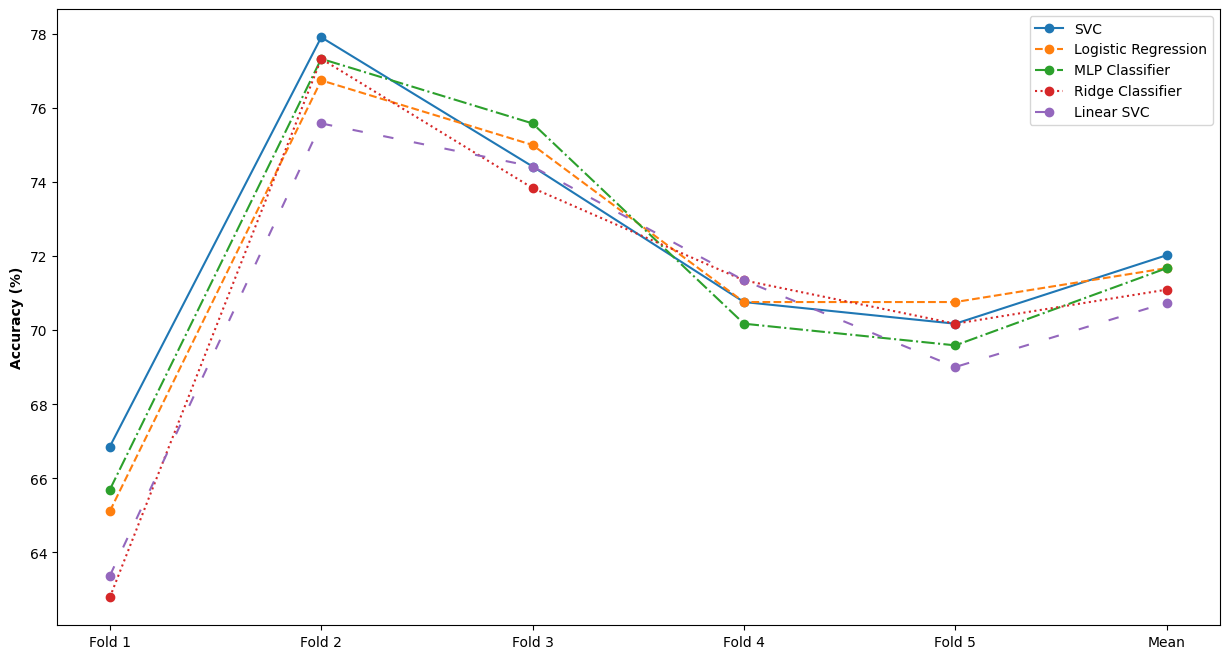

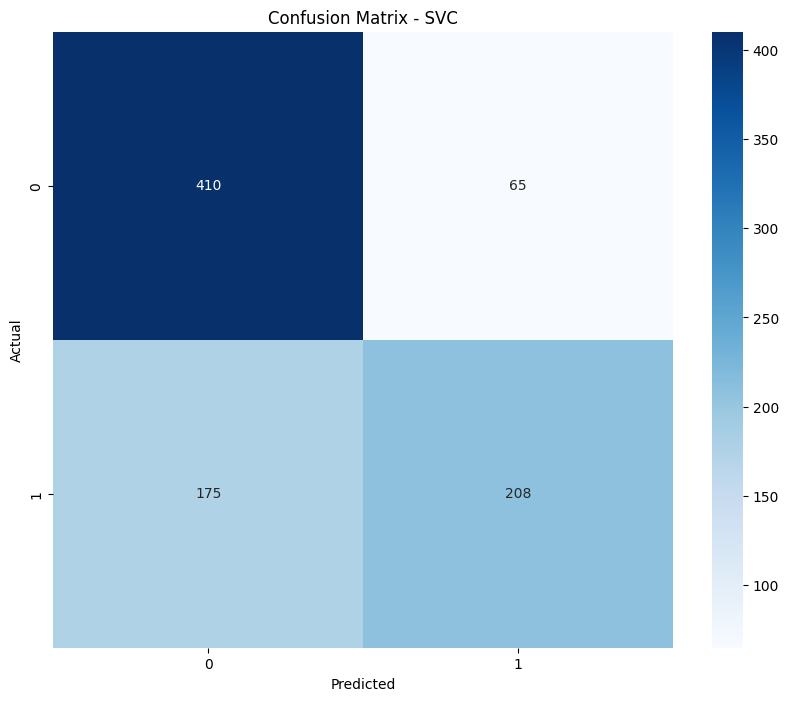

                                 Accuracy  Precision  Recall (Sensitivity)  Specificity  F1-Score                                      experiment
SVC                              0.720243   0.763740              0.543028     0.863158  0.629339  experiment_simple_butter_for_feature_reduction
Logistic Regression              0.716762   0.735574              0.569207     0.835789  0.636472  experiment_simple_butter_for_feature_reduction
MLP Classifier                   0.716741   0.731152              0.582331     0.825263  0.641490  experiment_simple_butter_for_feature_reduction
Ridge Classifier                 0.710948   0.724757              0.561381     0.831579  0.628951  experiment_simple_butter_for_feature_reduction
Linear SVC                       0.707446   0.716007              0.566644     0.821053  0.627863  experiment_simple_butter_for_feature_reduction
Linear Discriminant Analysis     0.707412   0.714921              0.571770     0.816842  0.629238  experiment_simple_butter_

In [17]:
all_results = []
X_y_data = []   #for save all X y for each experiment

for experiment in config['experiments']:
    print(f"Running {experiment['name']}...")
    df = select_duplicates(df, select= experiment['select'])    #df is the hole dataset 
    unique_patients = [7, 17] 
    X, y = compare_two(unique_patients, experiment_params=experiment)
    X_y_data.append({'X': X, 'y': y})  #save X y (features labels)
    results_df = find_best_model(X, y)
    results_df['experiment'] = experiment['name']   #add the name of the project
    #print(results_df.to_string())

    all_results.append(results_df)

final_results_df = pd.concat(all_results)
print(final_results_df.to_string())
#print(X)

## correlation matrix

if we have differnt method for extract features like wavelet or simple-- we will have also diff size and diff features

In [47]:
experiment_index = 0  #dataset for the firts experiment 
experiment_data = X_y_data[experiment_index]

X = experiment_data['X']
y= experiment_data['y']

print(f"X for experiment {experiment_index}:\n", X)
print(f"y for experiment {experiment_index}:\n", y)

X for experiment 0:
 [[ 4.46921017e+00  2.80000000e+01  8.40000000e+01 ... -1.23288414e+00
   0.00000000e+00  9.90000000e+01]
 [ 4.22381334e+00  1.60000000e+01  2.50000000e+01 ... -7.63242657e-01
   0.00000000e+00  1.00000000e+02]
 [ 4.11383182e+00  5.50000000e+01  7.00000000e+01 ... -4.89958625e-01
   0.00000000e+00  1.00000000e+02]
 ...
 [ 3.69533135e+00  3.60000000e+01  4.50000000e+01 ...  4.63004594e+00
   0.00000000e+00  1.00000000e+02]
 [ 3.99079436e+00  3.20000000e+01  4.70000000e+01 ...  3.35307329e-02
   0.00000000e+00  9.90000000e+01]
 [ 4.41975218e+00  7.60000000e+01  1.79000000e+02 ... -7.09386004e-01
   0.00000000e+00  1.00000000e+02]]
y for experiment 0:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0

In [48]:
X.size  ## size of all features and all lines

13728

In [49]:
##features of X with wavelet--> columns_name, 
#                    without-->stats
stats = ['entropy','no_zero_crossings', 'no_mean_crossings' ,'n5', 'n25', 'n75', 'n95', 'median', 'mean', 'std', 'var', 'rms', 'skew', 'kurtosis', 'min', 'max']
coeffs = ['cA5', 'cD5', 'cD4', 'cD3', 'cD2', 'cD1']
columns_names = [f"{stat}_{coeff}" for coeff in coeffs for stat in stats]
#df_columns_names = pd.DataFrame(columns=columns)
print(columns_names)

['entropy_cA5', 'no_zero_crossings_cA5', 'no_mean_crossings_cA5', 'n5_cA5', 'n25_cA5', 'n75_cA5', 'n95_cA5', 'median_cA5', 'mean_cA5', 'std_cA5', 'var_cA5', 'rms_cA5', 'skew_cA5', 'kurtosis_cA5', 'min_cA5', 'max_cA5', 'entropy_cD5', 'no_zero_crossings_cD5', 'no_mean_crossings_cD5', 'n5_cD5', 'n25_cD5', 'n75_cD5', 'n95_cD5', 'median_cD5', 'mean_cD5', 'std_cD5', 'var_cD5', 'rms_cD5', 'skew_cD5', 'kurtosis_cD5', 'min_cD5', 'max_cD5', 'entropy_cD4', 'no_zero_crossings_cD4', 'no_mean_crossings_cD4', 'n5_cD4', 'n25_cD4', 'n75_cD4', 'n95_cD4', 'median_cD4', 'mean_cD4', 'std_cD4', 'var_cD4', 'rms_cD4', 'skew_cD4', 'kurtosis_cD4', 'min_cD4', 'max_cD4', 'entropy_cD3', 'no_zero_crossings_cD3', 'no_mean_crossings_cD3', 'n5_cD3', 'n25_cD3', 'n75_cD3', 'n95_cD3', 'median_cD3', 'mean_cD3', 'std_cD3', 'var_cD3', 'rms_cD3', 'skew_cD3', 'kurtosis_cD3', 'min_cD3', 'max_cD3', 'entropy_cD2', 'no_zero_crossings_cD2', 'no_mean_crossings_cD2', 'n5_cD2', 'n25_cD2', 'n75_cD2', 'n95_cD2', 'median_cD2', 'mean_cD2

In [50]:
## make a df of features X and the appropriate name for each
df_features = pd.DataFrame(X ,columns= stats) 

In [51]:
df_features

,entropy,no_zero_crossings,no_mean_crossings,n5,n25,n75,n95,median,mean,std,var,rms,skew,kurtosis,min,max
0,4.469210,28.0,84.0,1.0,17.00,65.00,82.00,40.0,41.252571,26.730767,714.533922,41.252571,0.121500,-1.232884,0.0,99.0
1,4.223813,16.0,25.0,0.0,11.00,59.25,90.00,32.0,36.468000,28.532315,814.092976,36.468000,0.485720,-0.763243,0.0,100.0
2,4.113832,55.0,70.0,0.0,6.25,53.00,92.55,28.0,32.747273,28.545674,814.855523,32.747273,0.654485,-0.489959,0.0,100.0
3,3.503853,21.0,22.0,0.0,0.00,74.25,100.00,30.5,39.040000,37.909556,1437.134400,39.040000,0.411423,-1.382934,0.0,100.0
4,4.266093,30.0,47.0,0.0,12.00,46.00,76.00,27.0,30.680952,23.958498,574.009637,30.680952,0.745368,-0.074863,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,4.011285,18.0,25.0,0.0,4.00,49.00,94.00,23.0,31.172000,29.754032,885.302416,31.172000,0.837134,-0.353684,0.0,100.0
854,3.903182,53.0,80.0,0.0,2.00,36.00,78.00,14.0,23.057576,25.864748,668.985170,23.057576,1.259175,0.747553,0.0,100.0
855,3.695331,36.0,45.0,0.0,3.00,25.00,52.00,13.0,17.779259,20.105798,404.243125,17.779259,1.946188,4.630046,0.0,100.0
856,3.990794,32.0,47.0,0.0,3.00,39.00,77.05,13.0,23.995000,25.715413,661.282475,23.995000,1.073957,0.033531,0.0,99.0


In [52]:
## correlation matrix for the features 
correlation_matrix = df_features.corr(method='pearson')

In [53]:
print(correlation_matrix.to_string())

                    entropy  no_zero_crossings  no_mean_crossings        n5       n25       n75       n95    median      mean       std       var       rms      skew  kurtosis       min       max
entropy            1.000000           0.016447           0.251261  0.098771  0.667862  0.567445  0.469709  0.661467  0.664126  0.360795  0.204044  0.664126 -0.600030 -0.511375 -0.004624  0.543197
no_zero_crossings  0.016447           1.000000           0.838376 -0.196637 -0.254437 -0.091282  0.031212 -0.176699 -0.124477  0.050252  0.033648 -0.124490  0.174279  0.089887  0.011320  0.158300
no_mean_crossings  0.251261           0.838376           1.000000 -0.075524  0.068949 -0.008237  0.011856  0.030164  0.018610 -0.031703 -0.075185  0.018586 -0.013017 -0.010534  0.035452  0.151957
n5                 0.098771          -0.196637          -0.075524  1.000000  0.293229  0.074903 -0.022119  0.165782  0.132693 -0.075878 -0.084921  0.132691 -0.151388 -0.065170  0.052364 -0.057855
n25                0

In [54]:
import seaborn as sns

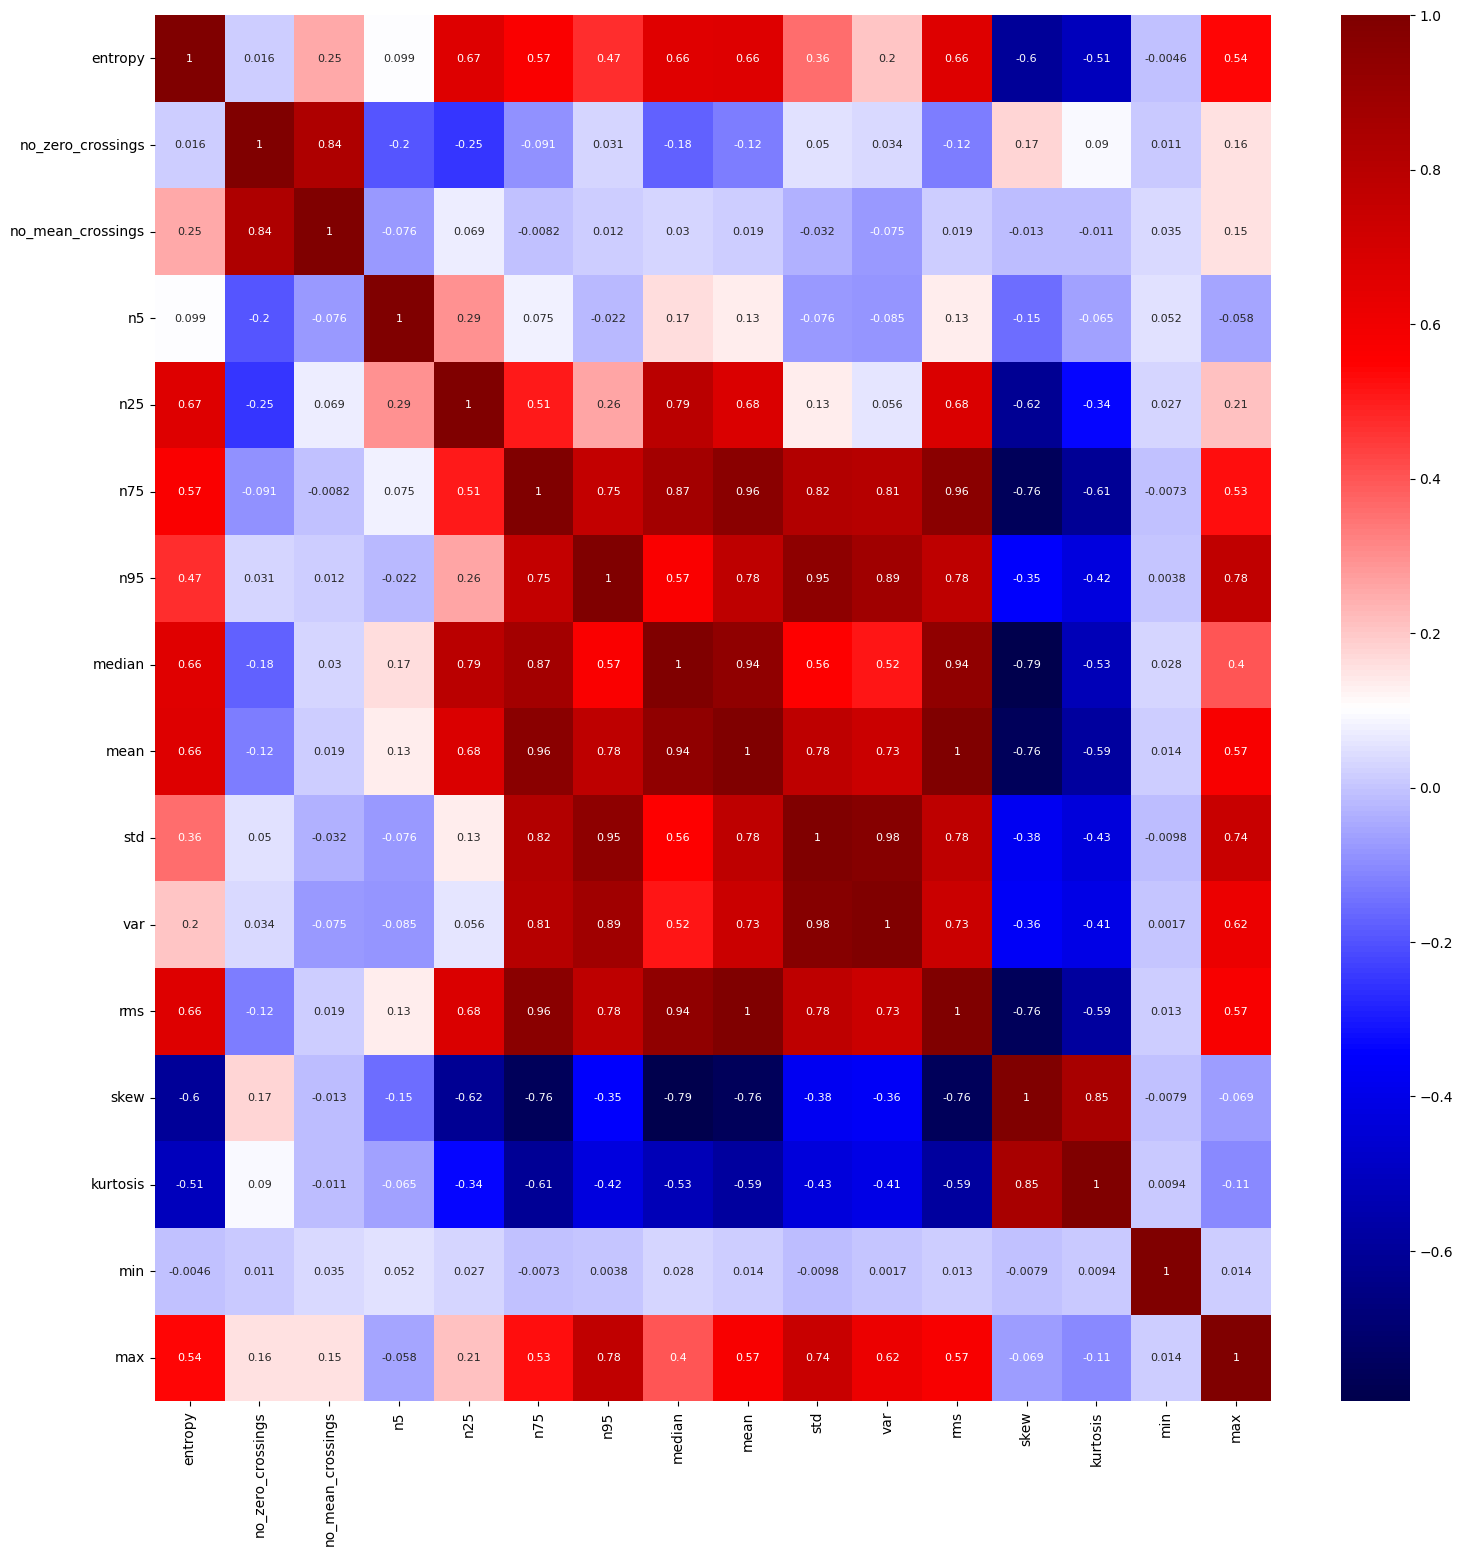

In [55]:
plt.figure(figsize=(18,18))
sns.heatmap(correlation_matrix, annot=True, cmap="seismic",annot_kws={"size":8})
plt.show()

In [56]:
## find the pairs of +- threshold similar features
threshold = 0.95
correlation_pairs = correlation_matrix.unstack()
correlation_pairs = correlation_pairs[correlation_pairs != 1]
sorted_pairs = correlation_pairs.sort_values(ascending=False)

strong_pairs = set()
for (i, j), correlation in correlation_pairs.items():
    if abs(correlation) >= threshold:
        pair = frozenset([i, j])
        strong_pairs.add((pair, correlation))

print(len(strong_pairs))
sorted_strong_pairs = sorted(strong_pairs, key=lambda x: abs(x[1]), reverse=True)

for pair, correlation in sorted_strong_pairs:
    print(f"Pair: {pair}, Correlation: {correlation:.4f}")

4
Pair: frozenset({'rms', 'mean'}), Correlation: 1.0000
Pair: frozenset({'std', 'var'}), Correlation: 0.9765
Pair: frozenset({'n75', 'rms'}), Correlation: 0.9618
Pair: frozenset({'n75', 'mean'}), Correlation: 0.9618


to drop --- all features to remove ---

In [57]:
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
#THERSHOLD

# Step 2: Find features that are highly correlated (above the threshold)
# These will be the features you might consider removing
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

# Drop the identified features from the original dataframe
df_reduced = df_features.drop(columns = to_drop)

# Print the features that were removed and the remaining features
print(f"Removed features: {to_drop}")
print(f"Remaining features: {df_reduced.columns.tolist()}")


Removed features: ['mean', 'var', 'rms']
Remaining features: ['entropy', 'no_zero_crossings', 'no_mean_crossings', 'n5', 'n25', 'n75', 'n95', 'median', 'std', 'skew', 'kurtosis', 'min', 'max']


In [60]:
filtered_columns = [col for col in column_names if any(key in col for key in to_drop)]

print(filtered_columns)

NameError: name 'column_names' is not defined

In [95]:
df_reduced
X_reduced = df_reduced.to_numpy()   ## X reduced features for new trainning

In [96]:
X_reduced   #array

array([[ 4.46921017e+00,  2.80000000e+01,  8.40000000e+01, ...,
        -1.23288414e+00,  0.00000000e+00,  9.90000000e+01],
       [ 4.22381334e+00,  1.60000000e+01,  2.50000000e+01, ...,
        -7.63242657e-01,  0.00000000e+00,  1.00000000e+02],
       [ 4.11383182e+00,  5.50000000e+01,  7.00000000e+01, ...,
        -4.89958625e-01,  0.00000000e+00,  1.00000000e+02],
       ...,
       [ 3.69533135e+00,  3.60000000e+01,  4.50000000e+01, ...,
         4.63004594e+00,  0.00000000e+00,  1.00000000e+02],
       [ 3.99079436e+00,  3.20000000e+01,  4.70000000e+01, ...,
         3.35307329e-02,  0.00000000e+00,  9.90000000e+01],
       [ 4.41975218e+00,  7.60000000e+01,  1.79000000e+02, ...,
        -7.09386004e-01,  0.00000000e+00,  1.00000000e+02]])

In [58]:
df_reduced  #all the columns and lines of features

,entropy,no_zero_crossings,no_mean_crossings,n5,n25,n75,n95,median,std,skew,kurtosis,min,max
0,4.469210,28.0,84.0,1.0,17.00,65.00,82.00,40.0,26.730767,0.121500,-1.232884,0.0,99.0
1,4.223813,16.0,25.0,0.0,11.00,59.25,90.00,32.0,28.532315,0.485720,-0.763243,0.0,100.0
2,4.113832,55.0,70.0,0.0,6.25,53.00,92.55,28.0,28.545674,0.654485,-0.489959,0.0,100.0
3,3.503853,21.0,22.0,0.0,0.00,74.25,100.00,30.5,37.909556,0.411423,-1.382934,0.0,100.0
4,4.266093,30.0,47.0,0.0,12.00,46.00,76.00,27.0,23.958498,0.745368,-0.074863,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,4.011285,18.0,25.0,0.0,4.00,49.00,94.00,23.0,29.754032,0.837134,-0.353684,0.0,100.0
854,3.903182,53.0,80.0,0.0,2.00,36.00,78.00,14.0,25.864748,1.259175,0.747553,0.0,100.0
855,3.695331,36.0,45.0,0.0,3.00,25.00,52.00,13.0,20.105798,1.946188,4.630046,0.0,100.0
856,3.990794,32.0,47.0,0.0,3.00,39.00,77.05,13.0,25.715413,1.073957,0.033531,0.0,99.0


to_drop το έχω βρει παρα πάνω ανάλογα με το threshold που έχω ορίσει

In [59]:
all_results_after_reduction = []


for experiment in config['experiments']:
    print(f"Running {experiment['name']} after feature reduction...")
    
    df = select_duplicates(df, select= experiment['select'])    #df is the hole dataset 
    X, y = compare_two(unique_patients, experiment_params=experiment)

    if(experiment['features']['method'] == 'wavelet'):
        df_features = pd.DataFrame(X ,columns= columns_names)
        to_drop = [col for col in columns_names if any(key in col for key in to_drop)]  #is to drop not only mean but mean_CDA ... all combinations ## to_drop para panw to brika
        df_reduced = df_features.drop(columns = to_drop)
        #X_reduced = df_reduced.to_numpy()
    else:
        df_features = pd.DataFrame(X ,columns= stats)  
        df_reduced = df_features.drop(columns = to_drop)        ##reduction of features
        #X_reduced = df_reduced.to_numpy()
    
   
    X_reduced = df_reduced.to_numpy()
    unique_patients = [7, 17] 
    results_df = find_best_model(X_reduced, y)
    results_df['experiment'] = experiment['name']
    all_results_after_reduction.append(results_df)

final_results_df = pd.concat(all_results_after_reduction)
print(final_results_df.to_string())
#print(X)

Running experiment_simple_butter_for_feature_reduction after feature reduction...
Amount of duplicate values: 
 False    77807
Name: count, dtype: int64

len of duplicates which removed: 
 0
Amount of duplicate values after droping: 
 False    77807
Name: count, dtype: int64
last


last


/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

Running experiment_wavelet_none_filter after feature reduction...
Amount of duplicate values: 
 False    77807
Name: count, dtype: int64

len of duplicates which removed: 
 0
Amount of duplicate values after droping: 
 False    77807
Name: count, dtype: int64
last
last


/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/glykeria/PPG_Classification/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

                                 Accuracy  Precision  Recall (Sensitivity)  Specificity  F1-Score                                      experiment
MLP Classifier                   0.716775   0.723497              0.584894     0.823158  0.643221  experiment_simple_butter_for_feature_reduction
Linear Discriminant Analysis     0.716762   0.724495              0.582262     0.825263  0.640948  experiment_simple_butter_for_feature_reduction
Ridge Classifier                 0.714450   0.732362              0.564046     0.835789  0.632593  experiment_simple_butter_for_feature_reduction
Logistic Regression              0.714429   0.736834              0.558749     0.840000  0.630143  experiment_simple_butter_for_feature_reduction
SVC                              0.713273   0.749558              0.537867     0.854737  0.622000  experiment_simple_butter_for_feature_reduction
Linear SVC                       0.710962   0.726194              0.561483     0.831579  0.629332  experiment_simple_butter_

In [108]:
print(final_results_df.to_string())

                                 Accuracy  Precision  Recall (Sensitivity)  Specificity  F1-Score                                      experiment
SVC                              0.716775   0.756452              0.540499     0.858947  0.625928  experiment_simple_butter_for_feature_reduction
Ridge Classifier                 0.715613   0.734396              0.564046     0.837895  0.633536  experiment_simple_butter_for_feature_reduction
Linear Discriminant Analysis     0.715592   0.724545              0.579665     0.825263  0.639038  experiment_simple_butter_for_feature_reduction
Logistic Regression              0.714429   0.735233              0.561381     0.837895  0.631274  experiment_simple_butter_for_feature_reduction
MLP Classifier                   0.713280   0.718397              0.584997     0.816842  0.640857  experiment_simple_butter_for_feature_reduction
Linear SVC                       0.709792   0.726601              0.556220     0.833684  0.626292  experiment_simple_butter_

In [246]:
import os
import shutil
if not os.path.exists('experiments'):
    os.makedirs('experiments')

def get_next_experiment_number():
    existing_experiments = [d for d in os.listdir('experiments') if os.path.isdir(os.path.join('experiments', d))]
    if not existing_experiments:
        return 1
    experiment_numbers = [int(name.split('_')[1]) for name in existing_experiments if name.startswith('experiment_')]
    return max(experiment_numbers) + 1

/tmp/ipykernel_130267/122395653.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Accuracy', y=final_results_df.index, hue='experiment', data=final_results_df, ci=None)


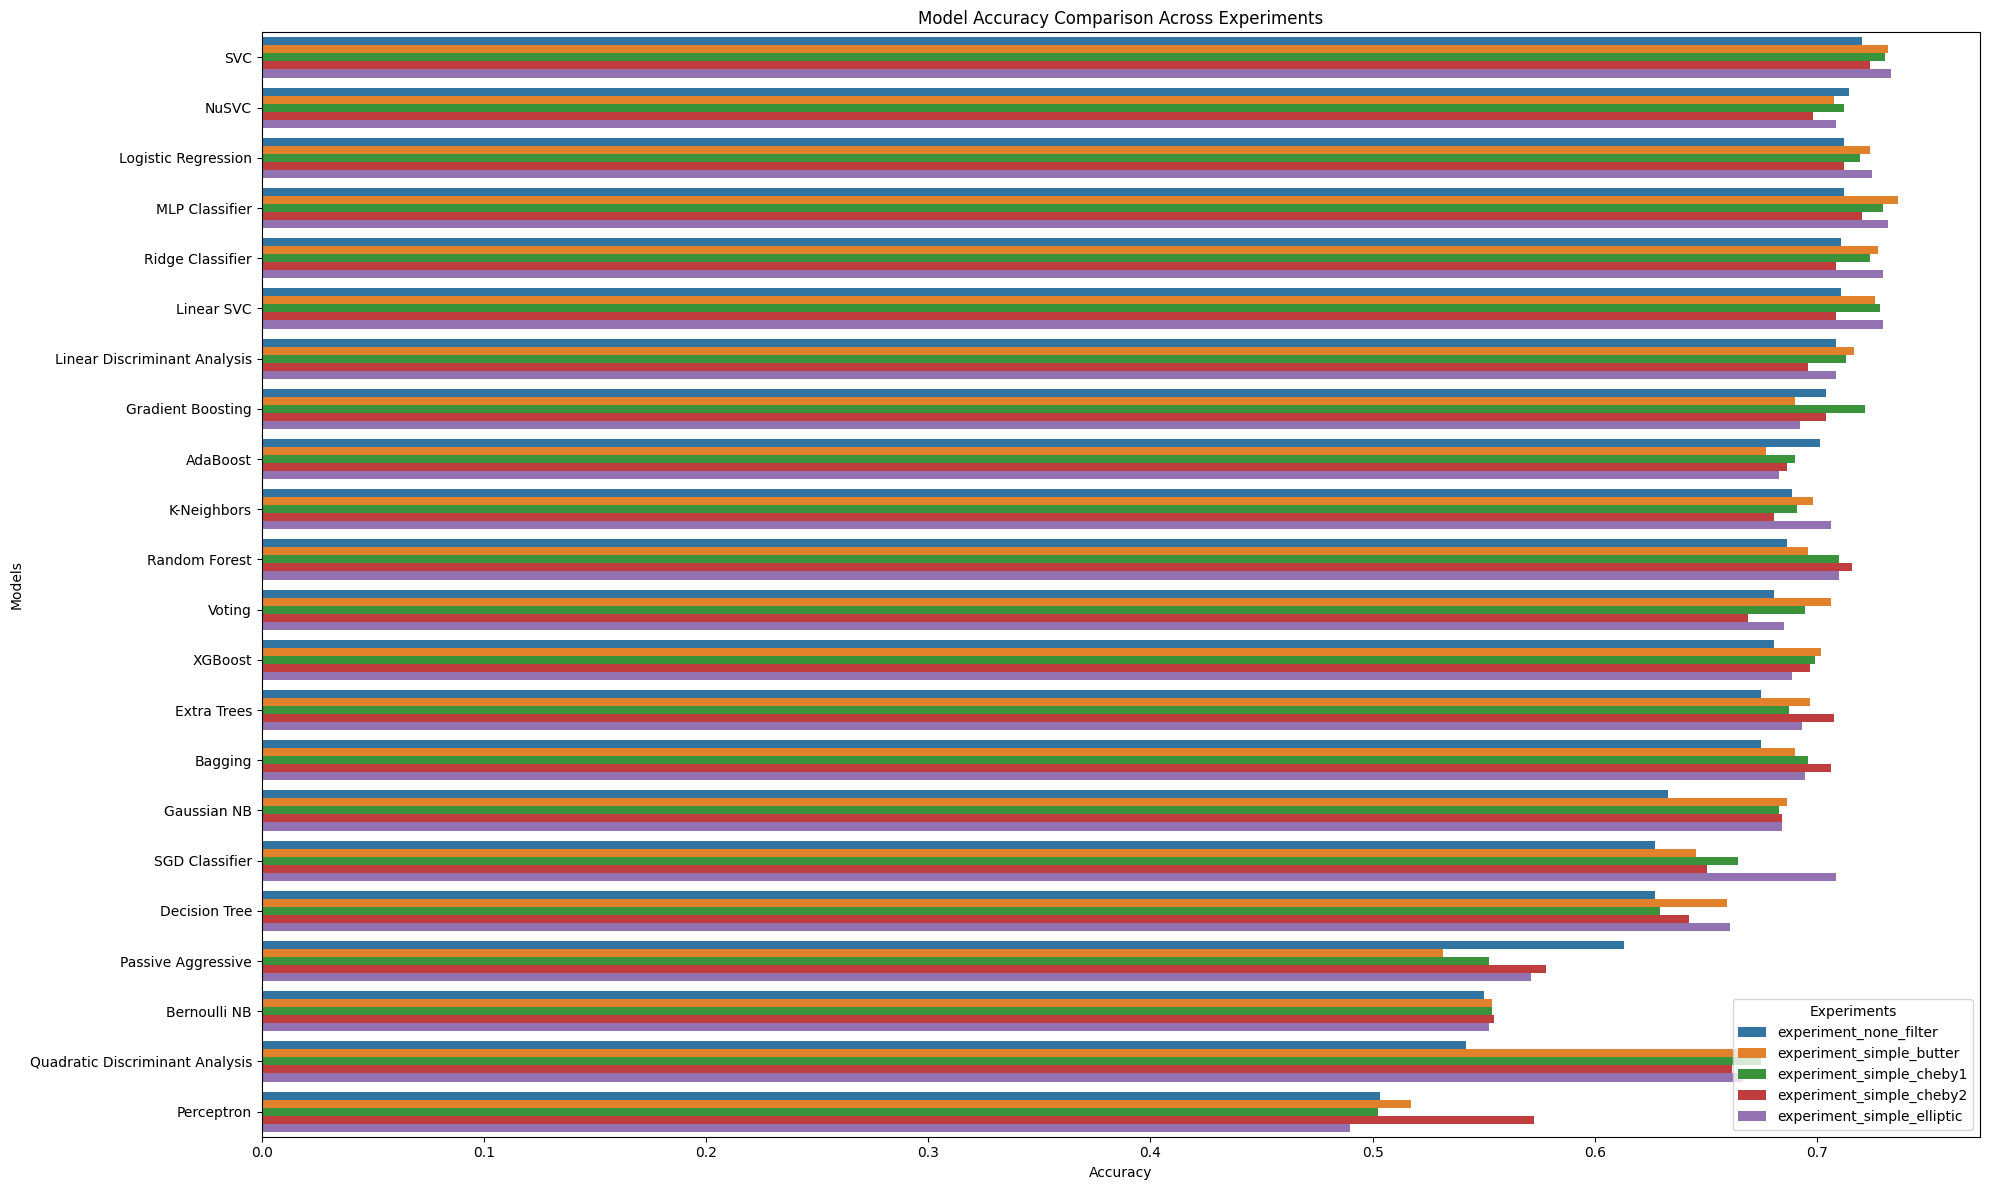

'experiments/experiment_2/config.yaml'

In [247]:
experiment_number = get_next_experiment_number()
experiment_folder = f'experiments/experiment_{experiment_number}'
    
os.makedirs(experiment_folder, exist_ok=True)

results_csv_path = os.path.join(experiment_folder, 'results.csv')
final_results_df.to_csv(results_csv_path, index=True)

#results_df = results_df.sort_values(by='Accuracy', ascending=False)
  
plt.figure(figsize=(20, 12))
sns.barplot(x='Accuracy', y=final_results_df.index, hue='experiment', data=final_results_df, ci=None)
plt.title('Model Accuracy Comparison Across Experiments')
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.legend(title='Experiments')
plt.tight_layout()
image_path = os.path.join(experiment_folder, 'model_accuracy_comparison.png')
plt.savefig(image_path)
plt.show()
plt.close()
    

config_file_path = 'config.yaml'
shutil.copy(config_file_path, os.path.join(experiment_folder, 'config.yaml'))

In [248]:
# import seaborn as sns
# final_results_df.to_csv('all_experiments_results.csv', index=True)

# plt.figure(figsize=(20, 12))
# sns.barplot(x='Accuracy', y=final_results_df.index, hue='experiment', data=final_results_df, ci=None)
# plt.title('Model Accuracy Comparison Across Experiments')
# plt.xlabel('Accuracy')
# plt.ylabel('Models')
# plt.legend(title='Experiments')
# plt.tight_layout()
# plt.savefig('model_accuracy_comparison.png')
# plt.show()





In [249]:
# Run this if you run the alternative steps in "find_best_model" function: real_values , predictions = find_best_model(X,y)

# confusion_matrix = metrics.confusion_matrix(real_values, predictions)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

# cm_display.plot()
# plt.show()

# # Calculate precision, recall, F1 score, and accuracy
# precision = metrics.precision_score(real_values, predictions)
# recall = metrics.recall_score(real_values, predictions)
# f1 = metrics.f1_score(real_values, predictions)
# accuracy = metrics.accuracy_score(real_values, predictions)

# # Print the results
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1 Score: {f1:.2f}')
# print(f'Accuracy: {accuracy:.2f}')

In [250]:
#find_best_model(X, y)

XGBoost - Finding best parameters/model 

We might this later - IGNORE for now

In [251]:
# import xgboost as xgb
# from sklearn.model_selection import StratifiedKFold, GridSearchCV

# def find_best_xgboost_model(X, y):
#     # Step 1 & 2: Scale the data
#     scaler = MinMaxScaler()          
#     X_scaled = scaler.fit_transform(X)
    
#     # Step 2: Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=42)
   
#     # Step 3: Define the parameter grid for XGBoost
#     # param_grid = {
#     #     'n_estimators': [100, 200, 300, 400, 500],
#     #     'max_depth': [3, 4, 5, 6, 7, 8],
#     #     'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
#     #     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     #     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#     #     'gamma': [0, 0.1, 0.2, 0.3],
#     #     'min_child_weight': [1, 2, 3, 4, 5]
#     # }

#     param_grid = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [3, 4, 5, 6],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'gamma': [0, 0.1, 0.2],
#     }
    
#     # Step 4: Set up the XGBoost classifier
#     xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
#     # Step 5: Set up the cross-validation and grid search
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=skf, verbose=2, n_jobs=-1)
    
#     # Step 6: Perform the grid search
#     grid_search.fit(X_train, y_train)
    
#     # Step 7: Get the best model and parameters
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_
    
#     # Step 8: Print the best parameters
#     print("Best Parameters found: ", best_params)
    
#     # Step 9: Test the best model's accuracy on the test set
#     y_test_pred = best_model.predict(X_test)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
#     print(f"Test Set Accuracy: {test_accuracy:.4f}")
    
#     return best_model, best_params

In [252]:
# model, params = find_best_xgboost_model(X, y)